It's interesting to analyze whether the works of the authors of the 20th century can be correctly identified. Table 1 displays the list of authors and the time during which these selected novels were written. The data set consists of 72 novels. I gathered some of the books from Project Gutenberg and added several books from my collection.  When selecting the corpus of books, I didn't collect poetry works, short stories, or text written originally in languages other than English. I limited my choice to the works of the 20th century, so the language will not be too different across books. I also thought that the authors' writing style might change over time. Maybe the novels from Pratchett's Discworld series that span several decades can be distinguished over time. For some novelists, I picked the novels written within a shorter time than for others. For example, the shortest period considered was eight years for J. London, and the longest was 38 years for J.R.R. Tolkien.



| Author  | Time period | Years| American/English| 
| --- | --- | ---| ---|
|Jack London | 1913-1920 | 8| American
|Terry Pratchett | 1983-1991| 9| English
|Douglas Adams | 1979-1988| 10| English
|Scott Fitzgerald | 1920-1934| 15| American
|George Orwell | 1933-1949| 17| English
|Isaac Asimov | 1950-1972 | 23| American
|Virginia Woolf | 1915-1938| 24| English
|Agatha Christie | 1926-1949| 24| English
|Somerset Maugham | 1908-1937 | 30| English
|Kurt Vonnegut | 1959-1990| 32| American
|Irwin Shaw | 1948-1982 | 35| American
|J.R.R. Tolkien | 1936-1973| 38| English

The text classification process usually includes the following steps: (1) data collection, (2) data analysis and labeling, (3) feature construction, weighting, and selection, (4) ML model selection and training, and (5) evaluation of the results. Previous studies have shown that words are the most significant indicator of authorship, but the most common words are not always the most informative. 

I extracted the most common words and their frequencies for each text. The matrix obtained from the corpus was sparse and had more than 1000 columns, each corresponding to a particular word. I reduced its dimension by applying PCA to each row of the matrix corresponding to the chunk. I built a word frequency matrix that highlights moderately rare words in a document. After that, I applied various statistical and machine learning methods to treat this problem as a classification problem. I was also interested in how similar the books of different authors are and how many dominant topics it can be.



Ok, let's import all necessary packages such as numpy, pandas, sklearn, nltk, gensim, etc. 

In [1]:
import string
import os
import re
import codecs
from collections import Counter
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, decomposition, ensemble
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
#from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.base import TransformerMixin
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, recall_score, classification_report
from sklearn import svm
from sklearn.decomposition import PCA


import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk import FreqDist

import gensim
from gensim import corpora
from gensim.models import LsiModel, LdaModel
from gensim.models.coherencemodel import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim

Here, I read all the books and assign short names to them. I also label the books by assigning the corresponding author's name to them.

In [2]:
# read novels and save them to the list
words_input_dir = '/Users/lilybird/Documents/github/nlp-authorship_attribution/books'

booknames = []
df = []
for filename in os.listdir(words_input_dir):
    if filename.endswith(".txt"):
        with open(os.path.join(words_input_dir, filename), "r", encoding='utf-8', errors='ignore') as input_file:
            booknames.append(os.path.basename(input_file.name))
            df.append(input_file.read())
            

# create book names and labels 
book_names = []
book_labels = []

for i in booknames:
    j = i.split('_')
    book_labels.append(j[0])
    book_names.append(j[1].split('.txt')[0])

print("Examples of labels: " + str(book_labels[0:5]))
print("Examples of book names: " + str(book_names[0:5]))

Examples of labels: ['maugham', 'pratchett', 'adams', 'christie', 'woolf']
Examples of book names: ['human', 'equal', 'hitchhikers', 'crooked', 'room']


We need to remove stop words, punctuation (except hyphen), short words, and lemmanize (lemmatization is usually more sophisticated than stemming). Stemming can match “car” to “cars” but lemmatization “car” handles matching “automobile”.

In [3]:
custom_stop = ["a", "about", "above", "after", "again", "against", "ain", "all", "am", "an", "and", "any", "are", "aren", "aren't", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "can", "couldn", "couldn't", "d", "did", "didn", "didn't", "do", "does", "doesn", "doesn't", "doing", "don", "don't", "down", "during", "each", "few", "for", "from", "further", "had", "hadn", "hadn't", "has", "hasn", "hasn't", "have", "haven", "haven't", "having", "he", "her", "here", "hers", "herself", "him", "himself", "his", "how", "i", "if", "in", "into", "is", "isn", "isn't", "it", "it's", "its", "itself", "just", "ll", "m", "ma", "me", "mightn", "mightn't", "more", "most", "mustn", "mustn't", "my", "myself", "needn", "needn't", "no", "nor", "not", "now", "o", "of", "off", "on", "once", "only", "or", "other", "our", "ours", "ourselves", "out", "over", "own", "re", "s", "same", "shan", "shan't", "she", "she's", "should", "should've", "shouldn", "shouldn't", "so", "some", "such", "t", "than", "that", "that'll", "the", "their", "theirs", "them", "themselves", "then", "there", "these", "they", "this", "those", "through", "to", "too", "under", "until", "up", "ve", "very", "was", "wasn", "wasn't", "we", "were", "weren", "weren't", "what", "when", "where", "which", "while", "who", "whom", "why", "will", "with", "won", "won't", "wouldn", "wouldn't", "y", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves", "could", "he'd", "he'll", "he's", "here's", "how's", "i'd", "i'll", "i'm", "i've", "let's", "ought", "she'd", "she'll", "that's", "there's", "they'd", "they'll", "they're", "they've", "we'd", "we'll", "we're", "we've", "what's", "when's", "where's", "who's", "why's", "would", "able", "abst", "accordance", "according", "accordingly", "across", "act", "actually", "added", "adj", "affected", "affecting", "affects", "afterwards", "ah", "almost", "alone", "along", "already", "also", "although", "always", "among", "amongst", "announce", "another", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "apparently", "approximately", "arent", "arise", "around", "aside", "ask", "asking", "auth", "available", "away", "awfully", "b", "back", "became", "become", "becomes", "becoming", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "believe", "beside", "besides", "beyond", "biol", "brief", "briefly", "c", "ca", "came", "cannot", "can't", "cause", "causes", "certain", "certainly", "co", "com", "come", "comes", "contain", "containing", "contains", "couldnt", "date", "different", "done", "downwards", "due", "e", "ed", "edu", "effect", "eg", "eight", "eighty", "either", "else", "elsewhere", "end", "ending", "enough", "especially", "et", "etc", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "except", "f", "far", "ff", "fifth", "first", "five", "fix", "followed", "following", "follows", "former", "formerly", "forth", "found", "four", "furthermore", "g", "gave", "get", "gets", "getting", "give", "given", "gives", "giving", "go", "goes", "gone", "got", "gotten", "h", "happens", "hardly", "hed", "hence", "hereafter", "hereby", "herein", "heres", "hereupon", "hes", "hi", "hid", "hither", "home", "howbeit", "however", "hundred", "id", "ie", "im", "immediate", "immediately", "importance", "important", "inc", "indeed", "index", "information", "instead", "invention", "inward", "itd", "it'll", "j", "k", "keep", "keeps", "kept", "kg", "km", "know", "known", "knows", "l", "largely", "last", "lately", "later", "latter", "latterly", "least", "less", "lest", "let", "lets", "like", "liked", "likely", "line", "little", "'ll", "look", "looking", "looks", "ltd", "made", "mainly", "make", "makes", "many", "may", "maybe", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "million", "miss", "ml", "moreover", "mostly", "mr", "mrs", "much", "mug", "must", "n", "na", "name", "namely", "nay", "nd", "near", "nearly", "necessarily", "necessary", "need", "needs", "neither", "never", "nevertheless", "new", "next", "nine", "ninety", "nobody", "non", "none", "nonetheless", "noone", "normally", "nos", "noted", "nothing", "nowhere", "obtain", "obtained", "obviously", "often", "oh", "ok", "okay", "old", "omitted", "one", "ones", "onto", "ord", "others", "otherwise", "outside", "overall", "owing", "p", "page", "pages", "part", "particular", "particularly", "past", "per", "perhaps", "placed", "please", "plus", "poorly", "possible", "possibly", "potentially", "pp", "predominantly", "present", "previously", "primarily", "probably", "promptly", "proud", "provides", "put", "q", "que", "quickly", "quite", "qv", "r", "ran", "rather", "rd", "readily", "really", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "respectively", "resulted", "resulting", "results", "right", "run", "said", "saw", "say", "saying", "says", "sec", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sent", "seven", "several", "shall", "shed", "shes", "show", "showed", "shown", "showns", "shows", "significant", "significantly", "similar", "similarly", "since", "six", "slightly", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "specifically", "specified", "specify", "specifying", "still", "stop", "strongly", "sub", "substantially", "successfully", "sufficiently", "suggest", "sup", "sure", "take", "taken", "taking", "tell", "tends", "th", "thank", "thanks", "thanx", "thats", "that've", "thence", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "thereto", "thereupon", "there've", "theyd", "theyre", "think", "thou", "though", "thoughh", "thousand", "throug", "throughout", "thru", "thus", "til", "tip", "together", "took", "toward", "towards", "tried", "tries", "truly", "try", "trying", "ts", "twice", "two", "u", "un", "unfortunately", "unless", "unlike", "unlikely", "unto", "upon", "ups", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "v", "value", "various", "'ve", "via", "viz", "vol", "vols", "vs", "w", "want", "wants", "wasnt", "way", "wed", "welcome", "went", "werent", "whatever", "what'll", "whats", "whence", "whenever", "whereafter", "whereas", "whereby", "wherein", "wheres", "whereupon", "wherever", "whether", "whim", "whither", "whod", "whoever", "whole", "who'll", "whomever", "whos", "whose", "widely", "willing", "wish", "within", "without", "wont", "words", "world", "wouldnt", "www", "x", "yes", "yet", "youd", "youre", "z", "zero", "a's", "ain't", "allow", "allows", "apart", "appear", "appreciate", "appropriate", "associated", "best", "better", "c'mon", "c's", "cant", "changes", "clearly", "concerning", "consequently", "consider", "considering", "corresponding", "course", "currently", "definitely", "described", "despite", "entirely", "exactly", "example", "going", "greetings", "hello", "help", "hopefully", "ignored", "inasmuch", "indicate", "indicated", "indicates", "inner", "insofar", "it'd", "keep", "keeps", "novel", "presumably", "reasonably", "second", "secondly", "sensible", "serious", "seriously", "sure", "t's", "third", "thorough", "thoroughly", "three", "well", "wonder", "a", "about", "above", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "another", "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are", "around", "as", "at", "back", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "behind", "being", "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con", "could", "couldnt", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight", "either", "eleven", "else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone", "everything", "everywhere", "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five", "for", "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his", "how", "however", "hundred", "ie", "if", "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made", "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much", "must", "my", "myself", "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own", "part", "per", "perhaps", "please", "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take", "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they", "thickv", "thin", "third", "this", "those", "though", "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what", "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will", "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves"]

In [4]:
# combine stop_words
stop = stopwords.words('english')
stop = " ".join(map(str, stop))
stop = word_tokenize(re.sub(r'[^\w\s]','',stop))
all_stop = stop + custom_stop

lemmatiser = WordNetLemmatizer()


# function to prepare text data for analysis
def text_preprocessing(text):
    #remove punctuation, numbers, and convert to lowercase
    #text = re.sub(r'[^\w\s]','',text).lower()
    #text = re.sub(r'\d+', '', text).lower()
    remove = string.punctuation
    remove = remove.replace("-", "") # don't remove hyphens
    pattern = r"[{}]".format(remove) # create the pattern
    text = re.sub(pattern, "", text).lower()
    # divide text into tokens
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]

    # remove stopwords
    # stop = stopwords.words('english')
    tokens = [token for token in tokens if token not in all_stop]

    # remove words less than three letters
    tokens = [word for word in tokens if len(word) >= 3]

    # lemmatize (remove inflectional endings, return the base of the words)
    lmtzr = WordNetLemmatizer()
    tokens = [lmtzr.lemmatize(word) for word in tokens]
    preprocessed_text= ' '.join(tokens)

    return preprocessed_text 

# apply to all data
for i in range(len(df)):
    df[i] = text_preprocessing(df[i])

Data before and after cleaning steps.

In [5]:
print('----------Before preprocessing----------')
print(df[1][2500:3000])
print('----------After preprocessing----------')
print(text_preprocessing(df[1][2500:3000]))

----------Before preprocessing----------
ce woke watched carefully place sir wizard blacksmith shrugged bad as bad as repeated blacksmith tone defying wizard considered story circumstance pleased hear speak smith son smith hanger-on sniggered wizard smiled son eighth son smith face stiffened turned villager rain stopping piss lot looked wizard raised eyebrow drum billet wizard billet thing talk waved hammer vaguely craning shoulder case wizard interesting audience departed smith drew couple stool bench bottle cupboard water tank poured
----------After preprocessing----------
woke watched carefully place sir wizard blacksmith shrugged bad bad repeated blacksmith tone defying wizard considered story circumstance pleased hear speak smith son smith hanger-on sniggered wizard smiled son eighth son smith face stiffened turned villager rain stopping piss lot looked wizard raised eyebrow drum billet wizard billet thing talk waved hammer vaguely craning shoulder case wizard interesting audience

Lets find and remove some top most common words these books share.

In [6]:
def find_top_most_common(df, num):
    common_words = []
    temp = FreqDist(word_tokenize(df[0]))
    common_words.append([word for word, word_count in Counter(temp).most_common(num)])
    for i in range(1, len(df)):
        temp = FreqDist(word_tokenize(df[i]))
        common_words.append([word for word, word_count in Counter(temp).most_common(num)])
        
    return common_words


def remove_common_words_from_books(numcommon, books):
    result = []
    common_words = find_top_most_common(books, numcommon)
    wcommon = set(common_words[0]).intersection(common_words[1])
    
    for book_counter in range(2, len(books)): # loop over all books
        wcommon = set(wcommon).intersection(common_words[book_counter])


    wcommon = list(wcommon)     
    for j in range(len(books)):
        tokens = [word for sent in nltk.sent_tokenize(books[j]) for word in nltk.word_tokenize(sent) if word not in wcommon]
        res = ' '.join(tokens)
        result.append(res)
        
    return wcommon, result


wcommon, res = remove_common_words_from_books(5000, df)
print(len(wcommon))
print(wcommon)
data = []
for i in range(len(res)):
    res_list = word_tokenize(res[i])
    data.append(res_list)

158
['feeling', 'step', 'began', 'feel', 'walked', 'reached', 'thick', 'needed', 'time', 'place', 'rest', 'thinking', 'dead', 'called', 'point', 'bring', 'chance', 'power', 'fact', 'small', 'open', 'mouth', 'stand', 'black', 'wall', 'voice', 'window', 'work', 'sense', 'body', 'asked', 'live', 'blue', 'kind', 'turn', 'floor', 'thing', 'long', 'passed', 'death', 'word', 'red', 'stay', 'speaking', 'hold', 'high', 'deal', 'large', 'great', 'moment', 'head', 'book', 'figure', 'speak', 'memory', 'food', 'afraid', 'story', 'sort', 'sit', 'paid', 'happy', 'lot', 'lay', 'light', 'carried', 'died', 'met', 'remained', 'eye', 'left', 'thought', 'sound', 'held', 'lie', 'changed', 'trouble', 'life', 'year', 'cut', 'looked', 'secret', 'sign', 'standing', 'late', 'child', 'told', 'hour', 'shoulder', 'order', 'face', 'case', 'piece', 'white', 'matter', 'heard', 'day', 'shut', 'coming', 'living', 'heart', 'telling', 'leave', 'short', 'number', 'led', 'knew', 'ago', 'man', 'making', 'remember', 'watched'

Split text on fragments of 2000 words.

In [7]:
# split on chunks
def chunks(doc, nsize):
    tokendoc = word_tokenize(doc)
    for i in range(0, len(tokendoc), nsize):
        yield tokendoc[i:i+nsize]
        
        

def splitOnChunks(chunk_size, df, book_labels, book_names):
    
    temp_chunks_df = []
    temp_labels = []
    temp_booknames = []
    books = []

    for i in range(len(df)):
        res_list = list(chunks(df[i], chunk_size))
        print(str(i) + " " + str(len(res_list)) + " " + str(len(res_list[len(res_list)-1])), end=", ")
        temp = []
        for j in range(len(res_list)): 
            if len(res_list[j]) >= chunk_size:
                strs = " ".join(map(str, res_list[j]))
                temp_chunks_df.append(strs)
                temp.append(strs)
                temp_labels.append(book_labels[i]) # append labels
                temp_booknames.append(book_names[i]) # append book names

    
        books.append(temp)
    
    return books, temp_chunks_df, temp_labels, temp_booknames

        

chunk_size = 2000 #words
books, chunks_df, labels, booknames = splitOnChunks(chunk_size, res, book_labels, book_names)

print('\n')
print(len(chunks_df))
print(len(labels))
print(len(booknames))
print(len(books))

0 34 1433, 1 10 1512, 2 8 647, 3 8 62, 4 6 982, 5 10 1588, 6 8 1819, 7 18 1378, 8 13 1446, 9 13 1500, 10 13 986, 11 11 1308, 12 10 294, 13 13 1539, 14 11 1949, 15 14 375, 16 27 552, 17 13 1792, 18 12 1288, 19 11 69, 20 11 1681, 21 11 1411, 22 7 1610, 23 23 1745, 24 11 713, 25 9 302, 26 39 568, 27 26 1451, 28 17 1287, 29 11 620, 30 34 1682, 31 19 1915, 32 19 1168, 33 26 1017, 34 12 214, 35 16 595, 36 10 985, 37 12 772, 38 10 1106, 39 10 1077, 40 8 1820, 41 7 1975, 42 13 499, 43 9 1552, 44 9 579, 45 8 1241, 46 9 1308, 47 10 1715, 48 12 846, 49 11 1937, 50 14 1098, 51 10 1198, 52 10 297, 53 8 1859, 54 7 509, 55 22 599, 56 22 145, 57 13 855, 58 20 1694, 59 9 350, 60 17 371, 61 15 1595, 62 11 833, 63 15 318, 64 8 947, 65 10 1687, 66 11 1771, 67 15 675, 68 5 1200, 69 16 1131, 70 14 721, 71 12 1283, 

904
904
904
72


In [8]:
#show counts for each authour
print(Counter(labels).keys())
print(Counter(labels).values()) 
lkeys = ['maugham', 'pratchett', 'adams', 'christie', 'woolf', 'london', 'vonnegut', 'shaw', 'tolkien', 'fitzgerald', 'orwell', 'asimov']


def pickOneBookForEach(lkeys, labels, booknames):
    selected_book = []
    for i in range(len(lkeys)):
        temp = [j for j in range(len(labels)) if labels[j] == lkeys[i]]
        ind = random.sample(temp, 1)
        selected_book.append(booknames[ind[0]])
        
    return selected_book
        
    
selected_books = pickOneBookForEach(lkeys, labels, booknames)
selected_books           

dict_keys(['maugham', 'pratchett', 'adams', 'christie', 'woolf', 'london', 'vonnegut', 'orwell', 'fitzgerald', 'tolkien', 'asimov', 'shaw'])
dict_values([79, 67, 48, 44, 64, 106, 53, 62, 77, 111, 60, 133])


['cakes',
 'equal',
 'tea',
 'crooked',
 'dalloway',
 'lady',
 'breakfast',
 'troubledair',
 'fellowship',
 'beatiful',
 'aspidistra',
 'stars']

In [9]:
# include all fragments from one book for each author in test data set
def createTrainTest(test_books, booknames, labels, data):
    train_labels = []
    train_booknames= []
    train_data = []
    test_labels = []
    test_booknames= []
    test_data = []
    
    for i in range(len(test_books)):
        for j in range(len(booknames)):
            if booknames[j] != test_books[i]:
                train_labels.append(labels[j])
                train_booknames.append(booknames[j])
                train_data.append(data[j])
            else:
                test_labels.append(labels[j])
                test_booknames.append(booknames[j])
                test_data.append(data[j])        
        
    return train_data, train_booknames, train_labels, test_data, test_booknames, test_labels

train_data, train_booknames, train_labels, test_data, test_booknames, test_labels  = createTrainTest(selected_books, booknames, labels, chunks_df)

print(len(train_labels))
print(len(test_labels))

print(Counter(train_labels).keys())
print(Counter(train_labels).values())

print(Counter(test_labels).keys())
print(Counter(test_labels).values())

10692
156
dict_keys(['maugham', 'pratchett', 'adams', 'christie', 'woolf', 'london', 'vonnegut', 'orwell', 'fitzgerald', 'tolkien', 'asimov', 'shaw'])
dict_values([939, 795, 566, 521, 759, 1256, 627, 732, 905, 1307, 711, 1574])
dict_keys(['maugham', 'pratchett', 'adams', 'christie', 'woolf', 'london', 'vonnegut', 'shaw', 'tolkien', 'fitzgerald', 'orwell', 'asimov'])
dict_values([9, 9, 10, 7, 9, 16, 9, 22, 25, 19, 12, 9])


In [10]:
# get balanced data sets
def selectSubset(N, lkeys, data, labels, booknames):
    new_data = []
    new_labels = []
    new_booknames = []
    
    for i in range(len(lkeys)):
        temp = [j for j in range(len(labels)) if labels[j] == lkeys[i]]
        ind = random.sample(temp, N)
        #ind = random.sample(list(enumerate(data)), N)
        #ind = [idx for idx, val in ind]
        new_data.append([data[i] for i in ind])
        new_labels.append([labels[i] for i in ind])
        new_booknames.append([booknames[i] for i in ind])
    
    new_data = [item for sublist in new_data for item in sublist]
    new_labels = [item for sublist in new_labels for item in sublist]
    new_booknames = [item for sublist in new_booknames for item in sublist]

    return new_data, new_labels, new_booknames
    
    
X_train, y_train, train_booknames = selectSubset(min(Counter(train_labels).values()), lkeys, train_data, train_labels, train_booknames)
X_test, y_test, test_booknames = selectSubset(min(Counter(test_labels).values()), lkeys, test_data, test_labels, test_booknames)

Let's count the word (unigram) occurrences in the corpus. I keep only words that occur at least in 20% of documents and less than 70% of the documents. After that, I construct a TF-IDF (term frequency-inverse document frequency) ma- trix that describes the relative frequency of the words in the document against their frequency in other documents. This approach reduces the weight given to common words and highlights moderately rare words in a document. 

           X         Y   author
0  37.583862  3.213182  maugham
1  38.523449  3.583402  maugham
2  38.954762  2.853780  maugham
3  39.655579  2.349957  maugham
4  39.634678  4.164611  maugham


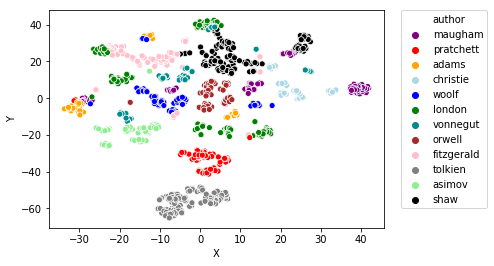

In [11]:
cv = CountVectorizer(ngram_range = (1,1), min_df = 50, max_df = 0.7)
# get a matrix of the token frequencies (sparse)
chunks_counts = cv.fit_transform(chunks_df)
tfidf_transformer = TfidfTransformer()
chunks_tfidf = tfidf_transformer.fit_transform(chunks_counts)

tsne = TSNE(n_components=2, random_state=0)
tsne_obj= tsne.fit_transform(chunks_tfidf.todense())
tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                        'Y':tsne_obj[:,1],
                        'author':labels})
print(tsne_df.head())

sns.scatterplot(x="X", y="Y",
              hue="author",
              palette=['purple','red', 'orange','lightblue','blue',
                       'green','darkcyan', 'brown', 'pink', 'grey', 'lightgreen', 'black'],
              legend='full',
              data=tsne_df);

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
#alternative approach

# use stratified (proportional) sampling so that each class is present in the test dataset
#X_train, X_test, y_train, y_test = train_test_split(chunks_df, labels, test_size=0.2, stratify = labels) 
#X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, stratify = y_valtest) 

#print(str(len(X_train)) + " " + str(len(y_train)))
#print(str(len(X_val)) + " " + str(len(y_val)))
#print(str(len(X_test)) + " " + str(len(y_test)))


#cv = CountVectorizer(ngram_range = (1,1), min_df = 50, max_df = 0.7)
# get a matrix of the token frequencies (sparse)
#chunks_counts = cv.fit_transform(X_train)
#tfidf_transformer = TfidfTransformer()
#X_train = tfidf_transformer.fit_transform(chunks_counts)

Build pipelines. Precision is TP/(TP + FP), recall is TP/(TP + FN), and F1 score is the harmonic mean of precision and recall.

In [12]:
class TransformerToDense(TransformerMixin ):
    
    def fit( self, X, y = None):
        return self 
    
    def transform(self, X, y = None):
        return X.todense()

    
pipe_lr = Pipeline([ ('vect', CountVectorizer(ngram_range = (1,1), min_df = 0.2, max_df = 0.7)),
                      ('tfidf', TfidfTransformer(use_idf = True)),
                      ('dense', TransformerToDense()),
                      ('pca', PCA(0.95)),
                      ('clf', LogisticRegression(C = 0.2, solver='lbfgs', multi_class='multinomial')) ])

pipe_svm = Pipeline([ ('vect', CountVectorizer(ngram_range = (1,1), min_df = 0.2, max_df = 0.7)),
                      ('tfidf', TfidfTransformer(use_idf = True)),
                      ('dense', TransformerToDense()),
                      ('pca', PCA(0.95)),
                      ('clf', svm.SVC(C=0.3, kernel='linear', degree=3, gamma='auto')) ])


pipe_rf = Pipeline([ ('vect', CountVectorizer(ngram_range = (1,1), min_df = 0.2, max_df = 0.7)),
                      ('tfidf', TfidfTransformer(use_idf = True)),
                      ('dense', TransformerToDense()),
                      ('pca', PCA(0.95)),
                      ('clf', ensemble.RandomForestClassifier(n_estimators = 80)) ])




def modelEvaluation(X_train, X_test, y_train, y_test, pipe = None):
    pipe.fit(X_train, y_train)
    predicted_trained = pipe.predict(X_train)
    predicted_test = pipe.predict(X_test)
    print(np.mean(predicted_trained == y_train))
    print(np.mean(predicted_test == y_test))
    print(classification_report(y_test, predicted_test))






print("---------- Logistic regression ----------")
modelEvaluation(X_train, X_test, y_train, y_test, pipe = pipe_lr)

print("---------- Support Vector Machine ----------")
modelEvaluation(X_train, X_test, y_train, y_test, pipe = pipe_svm)

print("---------- Random Forest ----------")
modelEvaluation(X_train, X_test, y_train, y_test, pipe = pipe_rf)



---------- Logistic regression ----------
1.0
1.0
              precision    recall  f1-score   support

       adams       1.00      1.00      1.00         7
      asimov       1.00      1.00      1.00         7
    christie       1.00      1.00      1.00         7
  fitzgerald       1.00      1.00      1.00         7
      london       1.00      1.00      1.00         7
     maugham       1.00      1.00      1.00         7
      orwell       1.00      1.00      1.00         7
   pratchett       1.00      1.00      1.00         7
        shaw       1.00      1.00      1.00         7
     tolkien       1.00      1.00      1.00         7
    vonnegut       1.00      1.00      1.00         7
       woolf       1.00      1.00      1.00         7

   micro avg       1.00      1.00      1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84

---------- Support Vector Machine ----------
1.0
1.0
              precision    rec

In [13]:
from urllib import request
from bs4 import BeautifulSoup

def getText(url, wcommon, lb, ub):
    clean_text = []
    html=request.urlopen(url).read()
    soup=BeautifulSoup(html,"lxml")
    raw=soup.get_text()
    text = text_preprocessing(raw)
    tokens = [word for word in nltk.word_tokenize(text) if word not in wcommon]
    tokens = tokens[lb:len(tokens)-ub]
    clean_text.append(' '.join(tokens))
    return clean_text

def modelPredict(X_train, X_test, y_train, pipe = None):
    pipe.fit(X_train, y_train)
    predicted_test = pipe.predict(X_test)
    print(predicted_test)
    


In [15]:
inputMaugham = "http://www.gutenberg.org/cache/epub/27198/pg27198.txt"
inputLondon = "http://www.gutenberg.org/cache/epub/1688/pg1688.txt"
inputChristie = "https://www.gutenberg.org/files/863/863-0.txt"
inputAsimov = "https://www.gutenberg.org/files/49819/49819-0.txt"
inputAdams = "http://www.gutenberg.org/cache/epub/13789/pg13789.txt"
inputFitzgerald = "http://www.gutenberg.org/cache/epub/4368/pg4368.txt"
inputVonnegut = "http://www.gutenberg.org/cache/epub/21279/pg21279.txt"
inputShaw = "https://archive.bookfrom.net/irwin-shaw/250118-top_of_the_hill.html"
inputPratchett = "https://archive.org/stream/TheNewDiscworldCompanion/Book%2029%20-%20Night%20Watch_djvu.txt"
inputOrwell = "http://www.george-orwell.org/Burmese_Days/5.html"
inputWoolf = "https://ebooks.adelaide.edu.au/w/woolf/virginia/w91w/"

new_book = getText(inputVonnegut, wcommon, 100, 100)
modelPredict(X_train, new_book, y_train, pipe = pipe_lr)

['vonnegut']
